In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

from jcopml.tuning import grid_search_params as gsp
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_correlation_matrix, plot_actual_vs_prediction, plot_residual
from jcopml.feature_importance import mean_score_decrease

import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [2]:
data = pd.read_csv('E:\Data Science\Python\machine learning exercises\dataset\\adm_data.csv', index_col='Serial No.')
data

GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
Serial No.                                                               
1                 337          118                  4  4.5   4.5  9.65   
2                 324          107                  4  4.0   4.5  8.87   
3                 316          104                  3  3.0   3.5  8.00   
4                 322          110                  3  3.5   2.5  8.67   
5                 314          103                  2  2.0   3.0  8.21   
...               ...          ...                ...  ...   ...   ...   
396               324          110                  3  3.5   3.5  9.04   
397               325          107                  3  3.0   3.5  9.11   
398               330          116                  4  5.0   4.5  9.45   
399               312          103                  3  3.5   4.0  8.78   
400               333          117                  4  5.0   4.0  9.66   

            Research  Chance of Admit   
Serial No.                              
1                  1              0.92  
2                  1              0.76  
3                  1              0.72  
4                  1              0.80  
5                  0              0.65  
...              ...               ...  
396                1              0.82  
397                1              0.84  
398                1              0.91  
399                0              0.67  
400                1              0.95  

[400 rows x 8 columns]

### Plot missing value

missing_value    %
GRE Score                      0  0.0
TOEFL Score                    0  0.0
University Rating              0  0.0
SOP                            0  0.0
LOR                            0  0.0
CGPA                           0  0.0
Research                       0  0.0
Chance of Admit                0  0.0

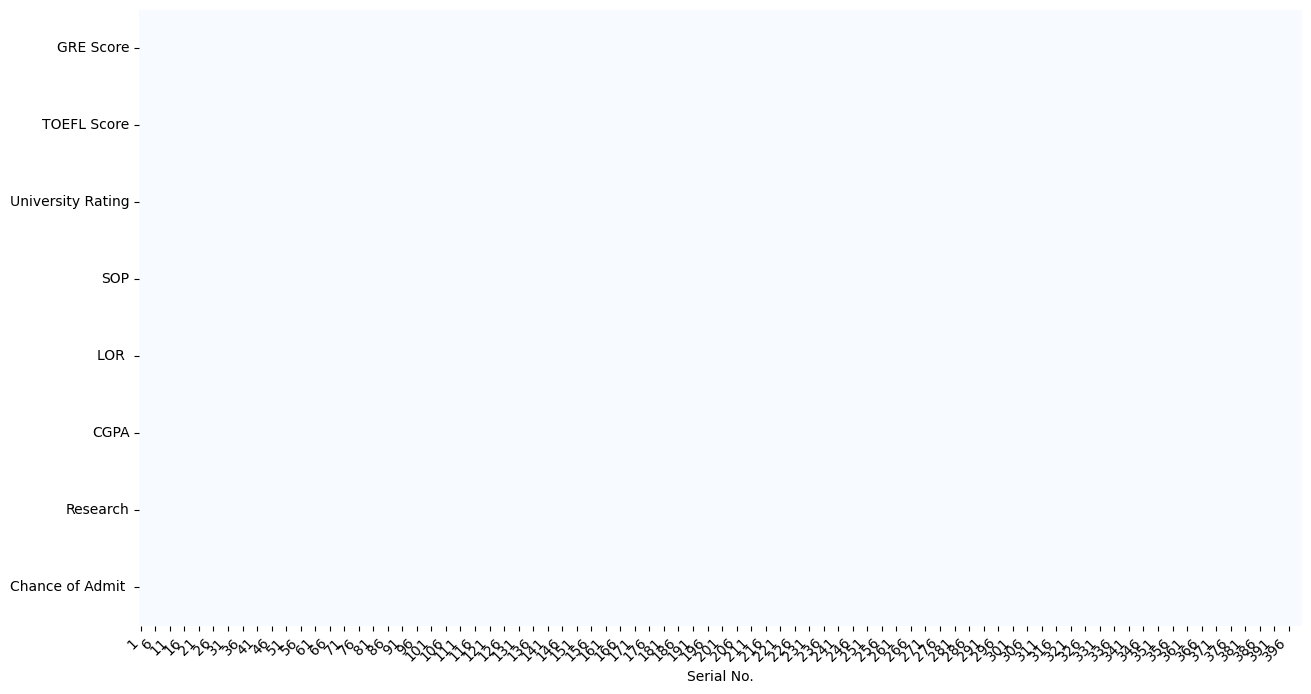

In [3]:
plot_missing_value(data, return_df=True)

### Plot data distribution

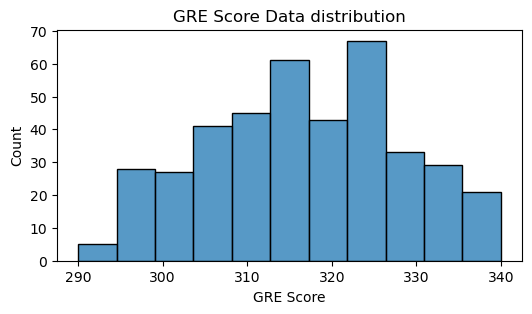

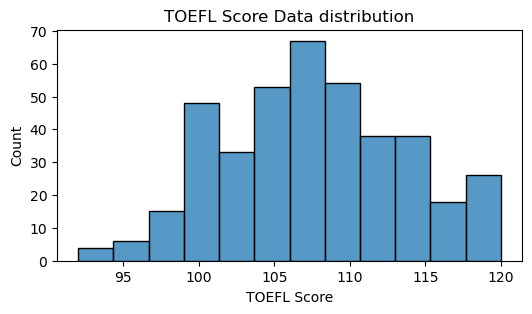

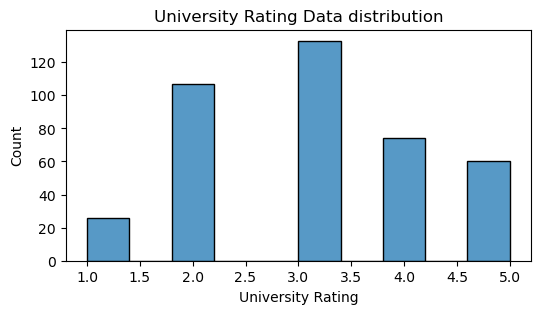

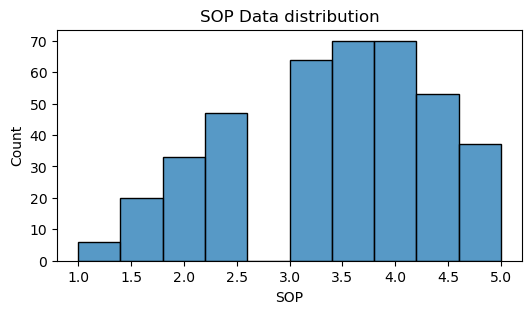

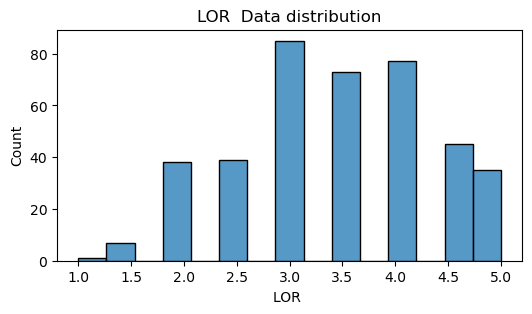

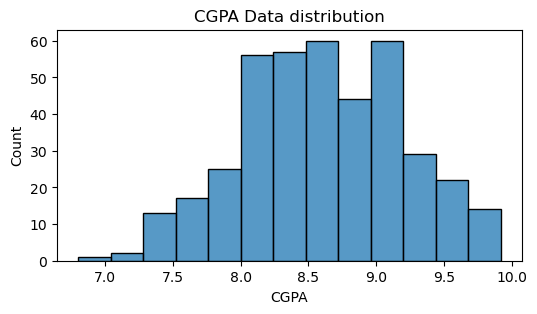

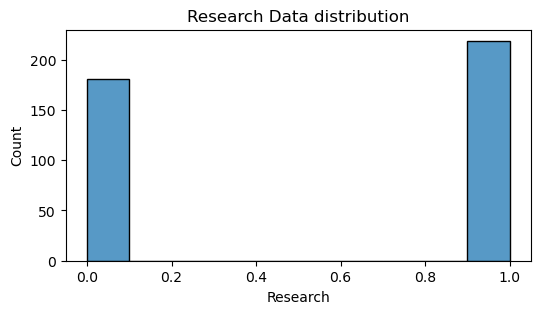

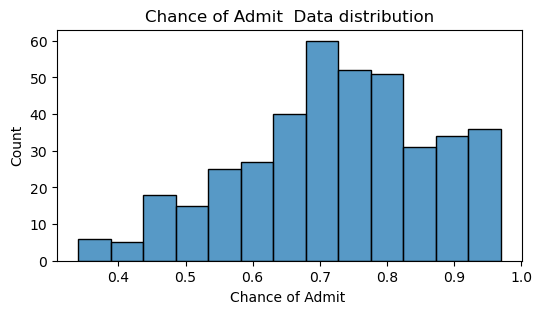

In [4]:
columns = list(data.columns)

for col in columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=data, x=col)
    plt.title(f'{col} Data distribution')

In [5]:
data.skew()

GRE Score           -0.062893
TOEFL Score          0.057216
University Rating    0.171260
SOP                 -0.275761
LOR                 -0.106991
CGPA                -0.065991
Research            -0.191582
Chance of Admit     -0.353448
dtype: float64

In [6]:
plot_correlation_matrix(data, target_col='Chance of Admit ')

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

### Dataset Splitting

In [7]:
X = data[['GRE Score', 'University Rating', 'CGPA', 'TOEFL Score']]
y = data['Chance of Admit ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((320, 4), (80, 4), (320,), (80,))

In [8]:
X_train.columns

Index(['GRE Score', 'University Rating', 'CGPA', 'TOEFL Score'], dtype='object')

In [9]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='standard'), ['GRE Score', 'TOEFL Score', 'CGPA']),
    ('categoric', cat_pipe(encoder='ordinal'), ['University Rating'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])


model = GridSearchCV(pipeline, gsp.linreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

# 0.7951946003191085 0.7685425529689583 0.8212082591487 -> other model score
# 0.8110886869208086 0.7430868659727885 0.8145271234274739 -> other model score

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'algo__fit_intercept': True}
0.7854860549089996 0.7582608505931757 0.7995013393523194


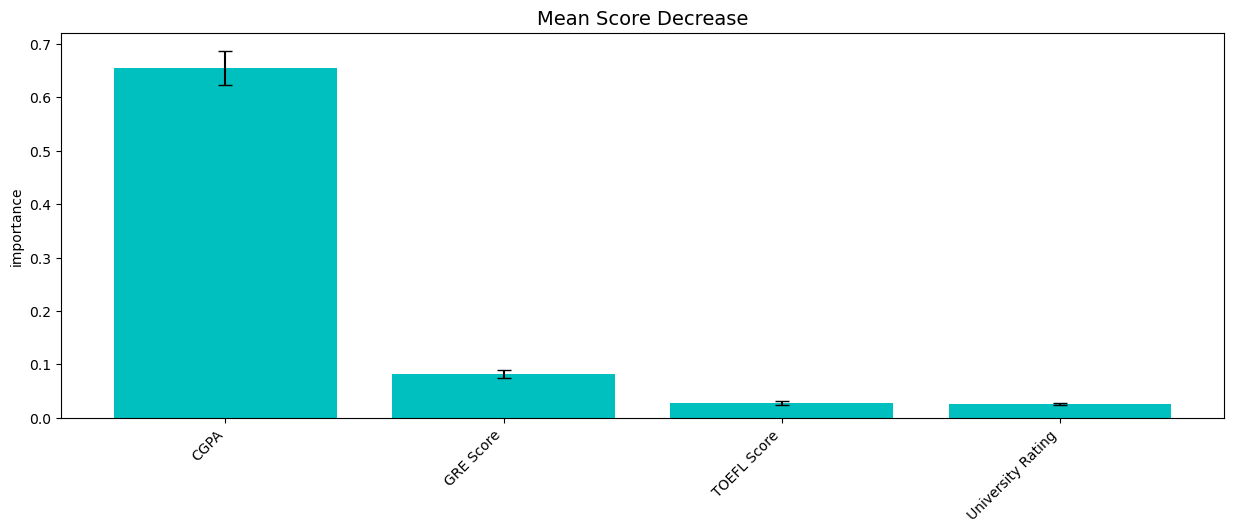

In [10]:
importance = mean_score_decrease(X_train, y_train, model, plot=True)

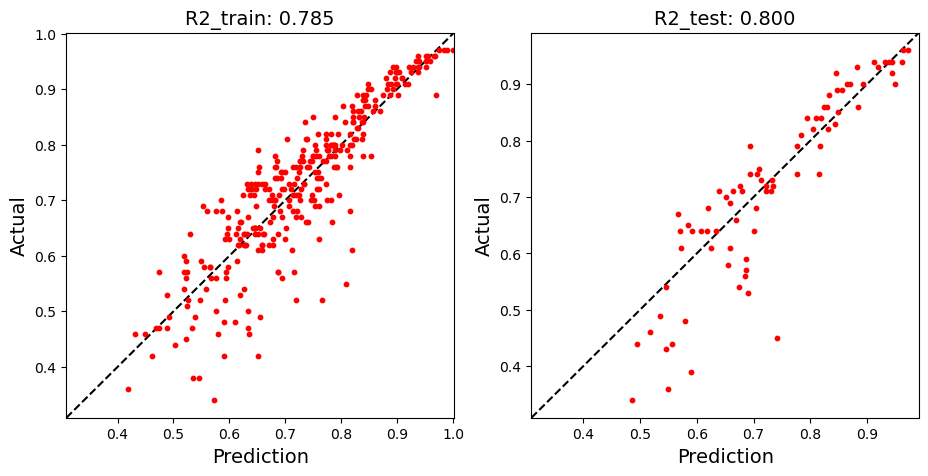

In [11]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

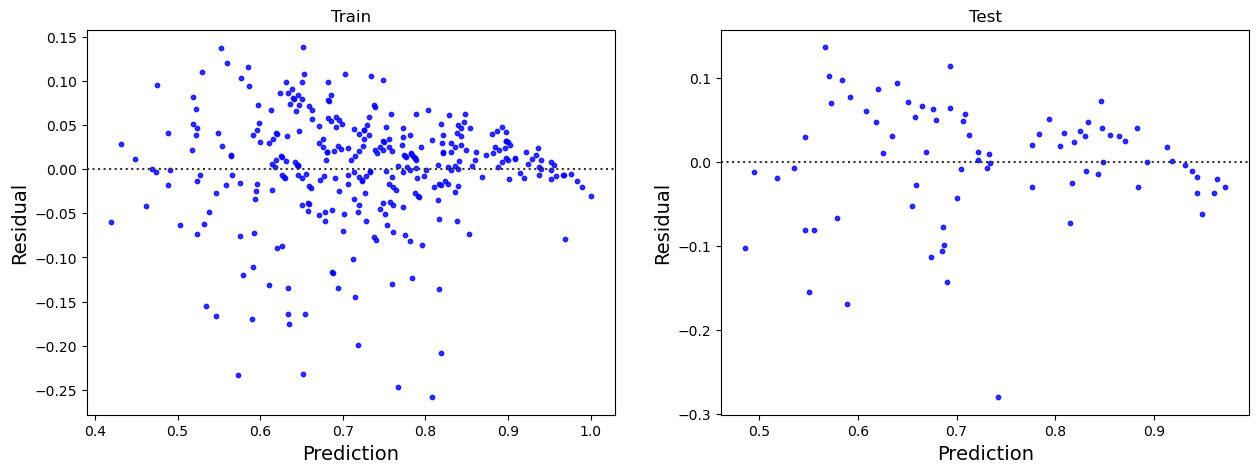

In [12]:
plot_residual(X_train, y_train, X_test, y_test, model)

Masih terdapat imbalance data pada hasil residual plot

### Modeling using Automl

In [13]:
from jcopml.automl import AutoRegressor

In [14]:
automl = AutoRegressor(num_feature=['GRE Score', 'TOEFL Score', 'CGPA'], cat_feature=['University Rating'])
automl.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
================== Best Model Info ==================
algo                      | ElasticNet
algo__alpha               | 0.011760546087079384
algo__fit_intercept       | True
algo__l1_ratio            | 0.23956189066697248

================================ Best Preprocessor Info =================================
categorical_imputer       | SimpleImputer(add_indicator=False, strategy='most_frequent')
categorical_encoder       | OneHotEncoder
numerical_imputer         | SimpleImputer(add_indicator=False, strategy='mean')

=========== Score ===========
Train: 0.7985032878710004
Valid: 0.7852829579390964
Test : 0.7077522259012943


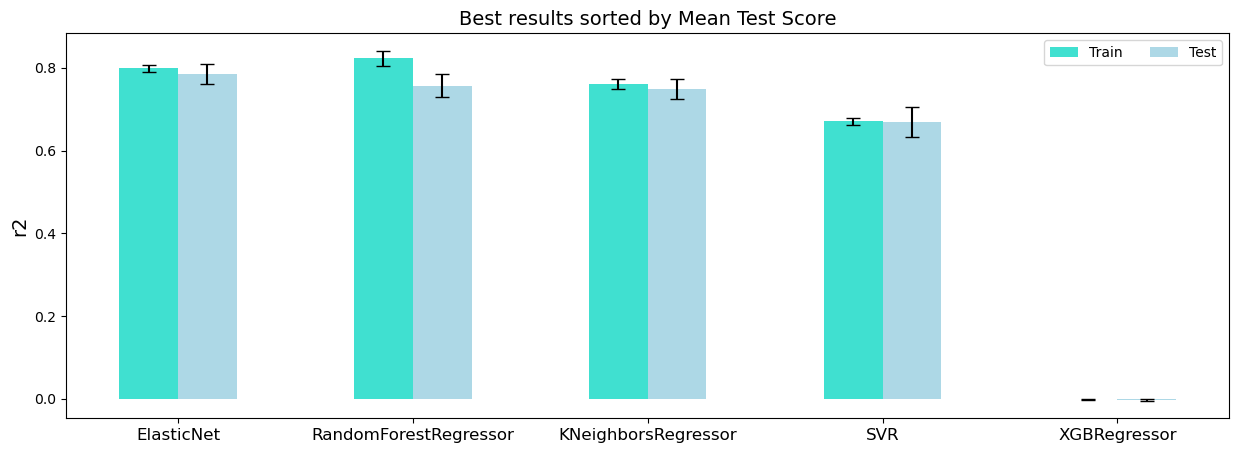

In [15]:
automl.plot_results()

### Automl Only ElasticNet

In [30]:
automl.fit(X, y, test_size=0.2, algo=['enet'], n_trial=100, poly=2, cv=3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
================== Best Model Info ==================
algo                      | ElasticNet
algo__alpha               | 0.004837646996135028
algo__fit_intercept       | True
algo__l1_ratio            | 0.7685540143063092

================================ Best Preprocessor Info =================================
categorical_imputer       | SimpleImputer(add_indicator=False, strategy='most_frequent')
categorical_encoder       | OneHotEncoder
numerical_imputer         | SimpleImputer(add_indicator=False, strategy='mean')
numerical_poly            | PolynomialFeatures
numerical_transformer     | PowerTransformer(method='yeo-johnson')

=========== Score ===========
Train: 0.7809309270467862
Valid: 0.7623825114993744
Test : 0.7908096991198592


In [38]:
# automl.best_estimators_